# Ejercicio 3 – Predicción de series temporales con Prophet

## ¿Qué es Prophet?

**Prophet** es una herramienta desarrollada por Facebook para facilitar el modelado de series temporales, especialmente útil cuando:

- Hay **tendencias y estacionalidades** claras.
- Hay **festivos o eventos especiales**.
- Se necesita una **herramienta sencilla pero flexible** sin profundos conocimientos estadísticos.

Es muy utilizado en contextos empresariales y educativos por su simplicidad y eficacia.

## ¿Cómo funciona?

Prophet descompone la serie en tres componentes principales:

\[
y(t) = g(t) + s(t) + h(t) + \varepsilon_t
\]

- `g(t)`: Tendencia (lineal, logística, piecewise)
- `s(t)`: Estacionalidad (diaria, semanal, anual)
- `h(t)`: Festivos o eventos especiales
- `ε`: Error aleatorio

---

## Flujo de trabajo

```mermaid
flowchart TD
    A[Dataset original] --> B[Renombrar columnas: ds, y]
    B --> C[Modelo Prophet básico]
    C --> D[Predicción futura]
    D --> E[Visualización]
    E --> F[Modelo con regresores externos]
    F --> G[Comparación de rendimiento]
```

---

## Requisitos previos
```bash
pip install prophet
```

---

## Parte 1 – Modelo Prophet

### Paso 1: Preparar el dataset

In [2]:
from prophet import Prophet
import pandas as pd

# Cargar y preparar datos
df = pd.read_csv("data/m5_consumo_energia_train.csv", index_col=0)
df = df.set_index(pd.to_datetime(df.index))

df['dt'] = df.index

# Prophet requiere columnas: 'ds' para fecha y 'y' para valor
train_df = df.rename(columns={"dt": "ds", "Energia Consumida": "y"})

Importing plotly failed. Interactive plots will not work.


In [3]:
val_df = pd.read_csv("data/m5_consumo_energia_test.csv", index_col=0)
val_df = val_df.set_index(pd.to_datetime(val_df.index))
val_df['dt'] = val_df.index
val_df = val_df.rename(columns={"dt": "ds", "Energia Consumida": "y"})

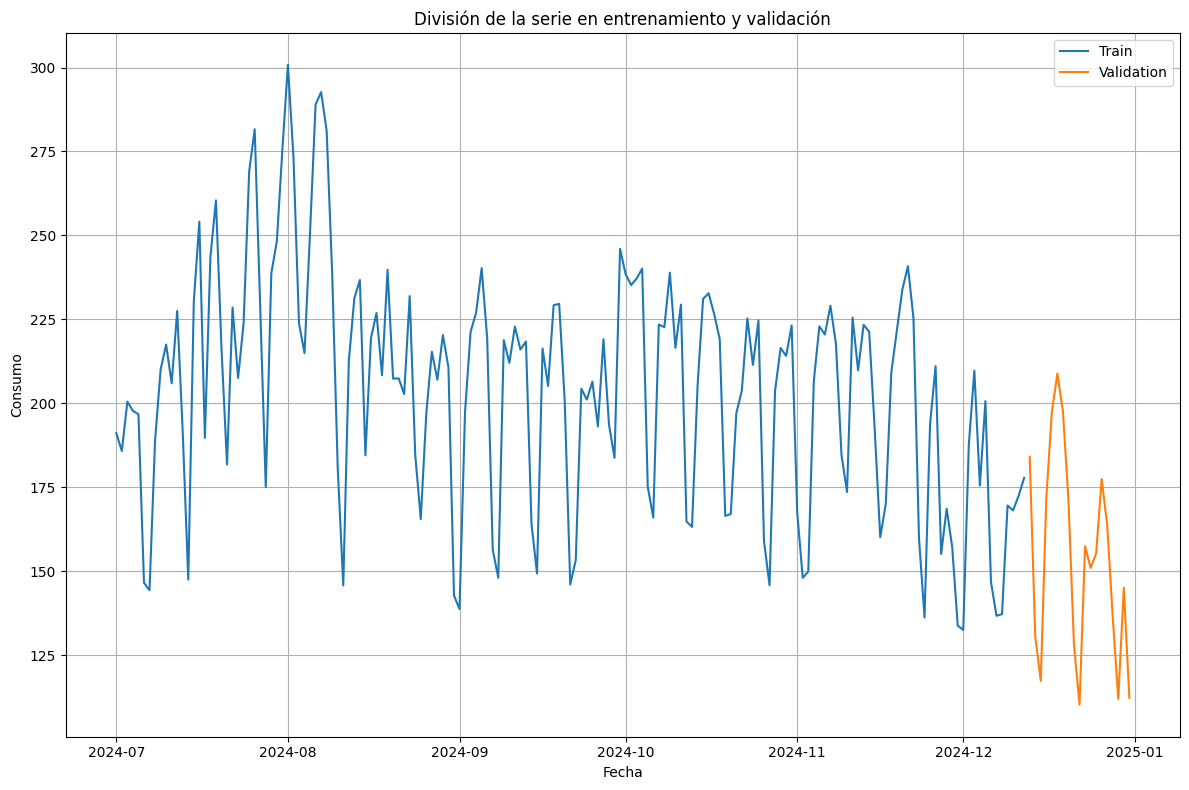

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(train_df.index, train_df["y"], label="Train")
plt.plot(val_df.index, val_df["y"], label="Validation")
plt.title("División de la serie en entrenamiento y validación")
plt.xlabel("Fecha")
plt.ylabel("Consumo")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

---

### Paso 2: Crear y entrenar el modelo

In [5]:
t_df = train_df[['ds','y']]
m = Prophet()
m.fit(t_df)

07:46:57 - cmdstanpy - INFO - Chain [1] start processing
07:47:00 - cmdstanpy - INFO - Chain [1] done processing


---

### Paso 3: Crear futuro y predecir

In [6]:
# Predecir los próximos 30 días
future = m.make_future_dataframe(periods=len(val_df))
forecast = m.predict(future)

---

### Paso 4: Visualizar resultado

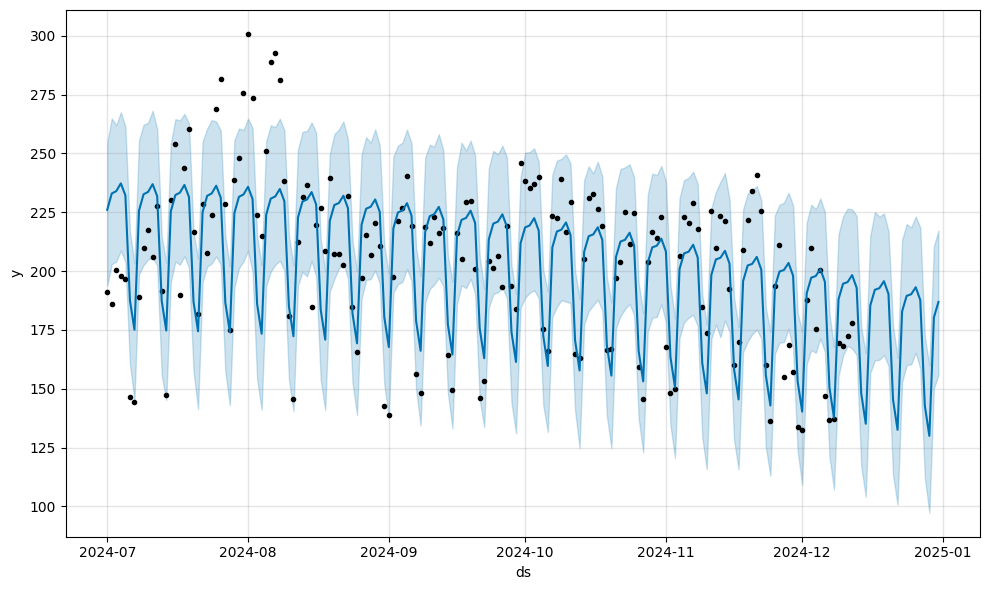

In [7]:
fig1 = m.plot(forecast)

#### Explicación

Este es el **gráfico principal de predicción de Prophet**. Incluye:

- La **predicción** realizada por el modelo (línea azul).
- Un **intervalo de confianza del 95%** alrededor de la predicción (franja azul claro).
- El **ajuste del modelo** a la serie original (puntos negros).

🔍 **Interpretación**:
- El propósito de los puntos es permitirte ver cómo el modelo ha capturado los patrones de la serie temporal y si hay una buena correspondencia entre los datos observados y las componentes ajustadas. Si los puntos negros siguen de cerca las curvas modeladas, eso sugiere que el modelo está ajustado correctamente.
- La línea azul continúa donde termina la serie original y muestra el valor estimado para todo el rango, incluyendo los días futuros.
- El área azul claro indica la **incertidumbre** del modelo en cada punto (más ancho = más incertidumbre).

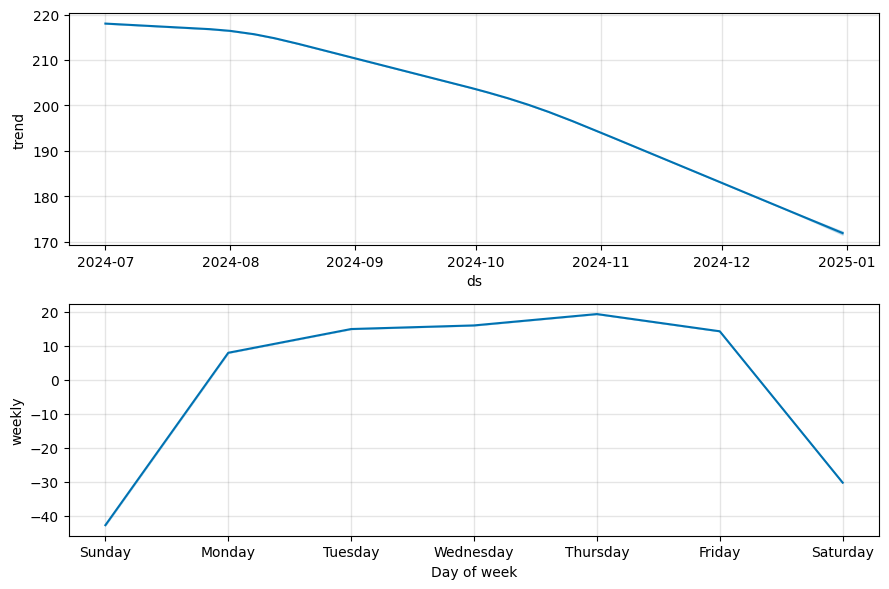

In [8]:
fig2 = m.plot_components(forecast)

### Explicación

Este genera **una visualización separada de los componentes del modelo Prophet**:

1. **Tendencia (trend)**:  
   La evolución a largo plazo del consumo.  
   Puedes ver si hay una subida, bajada, o tramos con crecimientos distintos.

2. **Estacionalidad semanal** (si existe):  
   Cómo varía el consumo según el día de la semana (por ejemplo, más consumo entre semana que los fines de semana).

3. **Estacionalidad anual** (si hay suficientes datos):  
   Fluctuaciones repetitivas a lo largo del año (más relevante con >1 año de datos).

4. **Otros componentes**:  
   Si has añadido **regresores** o **festivos**, también se incluirán aquí.

🔍 **Interpretación**:
- Este gráfico permite entender **qué patrones ha aprendido el modelo**, más allá de la predicción final.
- Es ideal para explicar el comportamiento estacional a otras personas no técnicas.

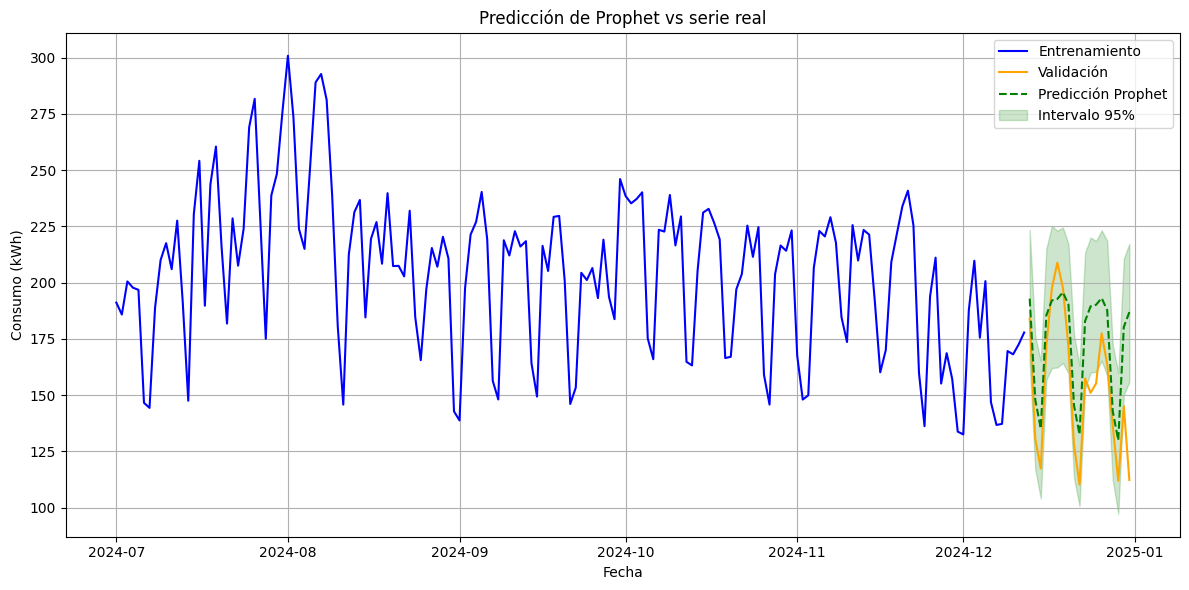

In [9]:
import matplotlib.pyplot as plt

# También puedes obtener el final de train como referencia
cutoff_date = train_df["ds"].max()

# Filtramos la parte futura del forecast
forecast_future = forecast[forecast["ds"] > cutoff_date]

# Graficamos todo
plt.figure(figsize=(12, 6))

# Serie real
plt.plot(train_df["ds"], train_df["y"], label="Entrenamiento", color="blue")
plt.plot(val_df["ds"], val_df["y"], label="Validación", color="orange")

# Predicción
plt.plot(forecast_future["ds"], forecast_future["yhat"], label="Predicción Prophet", color="green", linestyle="--")

# Intervalo de confianza
plt.fill_between(forecast_future["ds"],
                 forecast_future["yhat_lower"],
                 forecast_future["yhat_upper"],
                 color="green", alpha=0.2, label="Intervalo 95%")

# Formato
plt.title("Predicción de Prophet vs serie real")
plt.xlabel("Fecha")
plt.ylabel("Consumo (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

---

### Paso 5: Evaluar el rendimiento del modelo

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(val_df["y"], forecast_future["yhat"])
rmse = np.sqrt(mean_squared_error(val_df["y"], forecast_future["yhat"]))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 21.70
RMSE: 26.82


In [13]:
t_df['holidays'] = t_df[t_df.index.day > 5]
t_df.loc['2024/11/01'] = 1
t_df.loc['2024/12/06'] = 1
t_df.loc['2024/12/08'] = 1
m = Prophet(holidays=t_df['holidays'])

ValueError: Cannot set a DataFrame with multiple columns to the single column holidays

---

## Parte 2 – Modelado con regresores externos

Un **regresor** es una variable adicional que se incluye en el modelo para ayudar a explicar las variaciones del valor que queremos predecir.

En el contexto de consumo de energía, algunos ejemplos de regresores pueden ser:

- Temperatura (afecta al uso de aire acondicionado o calefacción)
- Humedad (relacionada con el uso de sistemas de ventilación o agua)
- Día de la semana (influye en el comportamiento de consumo en edificios)

### ¿Qué aporta un regresor?
**Mejora la precisión del modelo**
Al introducir una variable que está correlacionada con la serie temporal, el modelo puede anticiparse mejor a ciertos cambios o fluctuaciones que no se explican solo con el tiempo.

**Captura relaciones causales**
Un regresor puede reflejar una relación de causa y efecto real. Por ejemplo, sabemos que a mayor temperatura, probablemente aumenta el consumo energético por el uso de aire acondicionado.

**Permite simular escenarios**
Si el modelo incluye regresores, podemos simular “¿qué pasaría si...?” variara la temperatura o la humedad, lo que es útil para escenarios educativos o de planificación.

**Reduce el error**
En muchos casos, incluir regresores mejora métricas como MAE o RMSE, porque el modelo puede explicar parte del comportamiento que antes consideraba “ruido”.

### Paso 1: Visualizar correlaciones

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular matriz de correlación
corr = train_df[['y','Temperatura','Humedad']].corr()

# Representar heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación entre variables")
plt.tight_layout()
plt.show()

### Paso 2: Añadir regresores al dataframe

In [ ]:
# Preparar dataset con variables externas (Temperatura y Humedad)
train_reg_df = df.reset_index().rename(columns={
    "dt": "ds",
    "Energia Consumida": "y"
})

# Añadir regresores
train_reg_df["temperatura"] = df["Temperatura"].values
train_reg_df["humedad"] = df["Humedad"].values

In [ ]:
train_reg_df[['y','temperatura','humedad']].plot()

---

### Paso 3: Definir modelo con regresores

In [ ]:
m_reg = Prophet()
m_reg.add_regressor("temperatura")
m_reg.add_regressor("humedad")

m_reg.fit(train_reg_df)

---

### Paso 3: Crear futuro con regresores

In [ ]:
all_df = pd.concat([train_df, val_df], axis=0)
all_df

In [ ]:
# Generar mismo número de días futuros
future_reg = m_reg.make_future_dataframe(periods=len(val_df))
future_reg = future_reg.set_index(pd.to_datetime(future_reg['ds']))
# Aquí usamos el valor real de cada variable meteorológica
future_reg["temperatura"] = all_df['Temperatura']
future_reg["humedad"] = all_df['Humedad']


In [ ]:
future_reg

---

### Paso 4: Predecir y visualizar

In [ ]:
forecast_reg = m_reg.predict(future_reg)

# Visualización
fig1 = m_reg.plot(forecast_reg)
fig2 = m_reg.plot_components(forecast_reg)

In [ ]:
import matplotlib.pyplot as plt

# También puedes obtener el final de train como referencia
cutoff_date = train_df["ds"].max()

# Filtramos la parte futura del forecast
forecast_reg_future = forecast_reg[forecast_reg["ds"] > cutoff_date]

# Graficamos todo
plt.figure(figsize=(12, 6))

# Serie real
plt.plot(train_df["ds"], train_df["y"], label="Entrenamiento", color="blue")
plt.plot(val_df["ds"], val_df["y"], label="Validación", color="green")

# Predicción
plt.plot(forecast_reg_future["ds"], forecast_reg_future["yhat"], label="Predicción Prophet", color="orange", linestyle="--")

# Intervalo de confianza
plt.fill_between(forecast_reg_future["ds"],
                 forecast_reg_future["yhat_lower"],
                 forecast_reg_future["yhat_upper"],
                 color="blue", alpha=0.2, label="Intervalo 95%")

# Formato
plt.title("Predicción de Prophet vs serie real")
plt.xlabel("Fecha")
plt.ylabel("Consumo (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

---

### Paso 5: Evaluar el modelo

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(val_df["y"], forecast_reg_future["yhat"])
rmse = np.sqrt(mean_squared_error(val_df["y"], forecast_reg_future["yhat"]))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

## Capacidades de Prophet

Los parámetros que se utilizan al crear un modelo Prophet están relacionados con el manejo de las tendencias, estacionalidades y festividades. Aquí están los principales parámetros que puedes ajustar al usar **Prophet()**:

### 1. **`growth`**:
   - Especifica la forma de la tendencia.
     - **'linear'**: Utiliza una tendencia lineal.
     - **'logistic'**: Utiliza una tendencia logística (crecimiento con un límite superior definido).
   - **Por defecto** es **'linear'**.

### 2. **`changepoint_prior_scale`**:
   - Controla la flexibilidad de la tendencia. Es un parámetro regularizador que determina cuán rápido puede cambiar la tendencia en función de los puntos de cambio.
   - **Valores más altos** permiten que la tendencia cambie de forma más abrupta, mientras que **valores más bajos** restringen esos cambios.
   - **Por defecto** es **0.05**.

### 3. **`seasonality_prior_scale`**:
   - Ajusta la flexibilidad del componente estacional. Controla cuánto puede variar la estacionalidad a lo largo del tiempo.
   - **Valores altos** permiten mayor flexibilidad en la estacionalidad, mientras que **valores bajos** lo restringen.
   - **Por defecto** es **10.0**.

### 4. **`holidays_prior_scale`**:
   - Similar al parámetro de estacionalidad, pero controla la flexibilidad de los efectos de las festividades.
   - Si no se agregan festividades al modelo, este parámetro no tiene efecto.
   - **Por defecto** es **10.0**.

### 5. **`seasonality_mode`**:
   - Controla cómo se modela la estacionalidad.
     - **'additive'**: La estacionalidad se suma a la tendencia.
     - **'multiplicative'**: La estacionalidad multiplica la tendencia.
   - **Por defecto** es **'additive'**.

### 6. **`yearly_seasonality`**:
   - Activa o desactiva la estacionalidad anual. Si se pone en `True`, Prophet añadirá automáticamente un componente de estacionalidad anual.
   - **Por defecto** es **True** si la frecuencia de los datos es anual, de lo contrario, se ajusta automáticamente según los datos.

### 7. **`weekly_seasonality`**:
   - Activa o desactiva la estacionalidad semanal.
   - **Por defecto** es **True** si los datos contienen suficiente información para modelar una estacionalidad semanal.

### 8. **`daily_seasonality`**:
   - Activa o desactiva la estacionalidad diaria.
   - **Por defecto** es **True** si los datos contienen suficiente información para modelar una estacionalidad diaria.

### 9. **`seasonality`**:
   - Puedes proporcionar estacionalidades adicionales personalizadas para incluir en el modelo. Es útil cuando deseas añadir estacionalidades específicas (por ejemplo, trimestrales).
   - Acepta una lista de objetos que definen la estacionalidad adicional.

### 10. **`holidays`**:
   - Puedes añadir un dataframe de festividades que afecten la serie temporal. Las festividades pueden ser estacionales o específicas de ciertos días (por ejemplo, Navidad, Año Nuevo).
   - Debe ser un DataFrame con las columnas **'holiday'** (nombre de la festividad), **'ds'** (fecha de la festividad) y **'lower_window' y 'upper_window'** (para definir el rango de días de la festividad).

### 11. **`interval_width`**:
   - Define el ancho del intervalo de confianza para las predicciones. Este parámetro controla el rango en el que se espera que se encuentren las predicciones.
   - **Por defecto** es **0.80**, lo que significa un intervalo de confianza del 80%.

### 12. **`uncertainty_samples`**:
   - Determina cuántas muestras de incertidumbre se generan para estimar el intervalo de confianza.
   - **Por defecto** es **1000**, lo que genera 1000 muestras.

### 13. **`cap` y `floor`**:
   - Cuando se utiliza el modelo con **'logistic'** en lugar de **'linear'**, puedes definir un valor máximo (**cap**) y mínimo (**floor**) para limitar la tendencia logística. Esto es útil cuando esperas que la serie temporal tenga un crecimiento limitado (por ejemplo, usuarios de una plataforma que no pueden superar un número máximo de usuarios).

### 14. **`mcmc_samples`**:
   - Si se establece un valor mayor que cero, Prophet utiliza un enfoque basado en MCMC (Monte Carlo Markov Chain) para las predicciones, lo que puede ser útil cuando se requiere una estimación más precisa de la incertidumbre.

### 15. **`interval_width`**:
   - Determina el ancho del intervalo de predicción (por ejemplo, 0.95 correspondería a un intervalo de confianza del 95%).

### 16. **`prophet.growth()`**:
   - Este parámetro se refiere al crecimiento de la serie temporal, que puede ser lineal o logístico.

---

### Ejemplo de ajuste de parámetros en Prophet
```python
modelo = Prophet(
    growth='linear',               # Tendencia lineal
    changepoint_prior_scale=0.05,  # Flexibilidad de los puntos de cambio
    seasonality_prior_scale=10.0,  # Flexibilidad de la estacionalidad
    holidays_prior_scale=10.0,     # Flexibilidad de las festividades
    yearly_seasonality=True,       # Estacionalidad anual
    weekly_seasonality=True        # Estacionalidad semanal
)

```

---

## ✅ Resultado esperado

- Preparar tus datos en formato adecuado para Prophet.
- Entrenar modelos con y sin regresores externos.
- Visualizar tendencias, estacionalidades y componentes.
- Comparar predicciones y detectar el efecto de variables como temperatura o humedad.